In [1]:
using Model
using LogExpFunctions: softmax
using CairoMakie

In [2]:
decisions = Model.loaddata("../../data.jsonl");
filter!(d -> length(judges(d)) > 0, decisions);

In [3]:
problem = BPatGModel(decisions);

In [6]:
@time post = Model.sample(problem, 1000, 6; backend=:ReverseDiff)

6415.431007 seconds (87.34 M allocations: 38.284 GiB, 0.09% gc time, 0.70% compilation time)


DynamicHMCPosterior with 6000 samples and parameters (:α, :zs, :σs, :zy, :σy, :zj, :σj, :zt, :σt)

In [40]:
# using InferenceObjects
# idata = convert_to_inference_data(problem, post)

In [10]:
Model.checkconvergence(post)[3]

Hamiltonian Monte Carlo sample of length 6000
  acceptance rate mean: 0.9, 5/25/50/75/95%: 0.65 0.88 0.94 0.98 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 0%, 5 => 100%

# Judge results

In [11]:
function topkgroups(groups, k=10)
    js = reduce(vcat, groups)
    df = DataFrame(groups=js)
    df = combine(groupby(df, :groups), nrow => :count)
    df = sort!(df, :count; rev=true)
    first(df.groups, k)
end

topkgroups (generic function with 2 methods)

In [12]:
function average_deviation(post, element; group=:judges, groupsize=5)
    params = if group == :judges
        (zs=:zj, σs=:σj)
    elseif group == :cpc
        (zs=:zt, σs=:σt)
    else
        throw(ArgumentError("Unknown group."))
    end

    map(post) do s
        zs = getproperty(s, params.zs)
        ze = getindex(zs, element)
        σs = getproperty(s, params.σs)
        αs = s.α
        softmax(vcat(0, αs .+ (ze .* σs) ./ groupsize)) - softmax(vcat(0, αs))
    end
end

average_deviation (generic function with 1 method)

In [13]:
function plot_average_deviation(ax, probs)
    for (i, vals) in enumerate(eachcol(hcat(probs...)'))
        m, sd = mean(vals), std(vals)
        errorbars!(ax, [i], [m], [sd]; cycle=:color)
        scatter!(ax, i, m)
    end    
end

plot_average_deviation (generic function with 1 method)

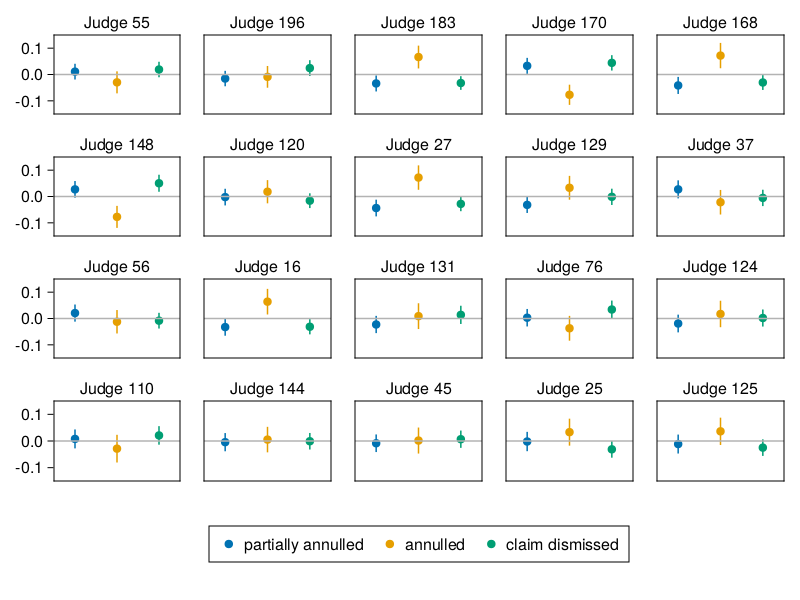

In [25]:
let groups = topkgroups(problem.js, 20)
    ncols = 5
    label = "Judge"
    
    fig = Figure(resolution=(800, 600))
    for (i, group) in enumerate(groups)
        probs = average_deviation(post, group)
        pos = fldmod1(i, ncols)
        ax = Axis(fig[pos...]; subtitle = "$label $group")
        plot_average_deviation(ax, probs)
        hlines!(ax, 0; color=:grey70)
        hidexdecorations!(ax)
        ax.ygridvisible = false
        xlims!(ax, 0.5, 3.5)
        ylims!(ax, -.15, .15)
        last(pos) != 1 && (ax.yticksvisible = false; ax.yticklabelsvisible=false)
    end

    colors = Makie.wong_colors()
    lelems = [MarkerElement(color=colors[c], marker=:circle) for c in 1:3]
    Legend(fig[end+1, :], lelems, problem.outcome_labels; nbanks=3)
    
    fig
end

# Technology outcomes

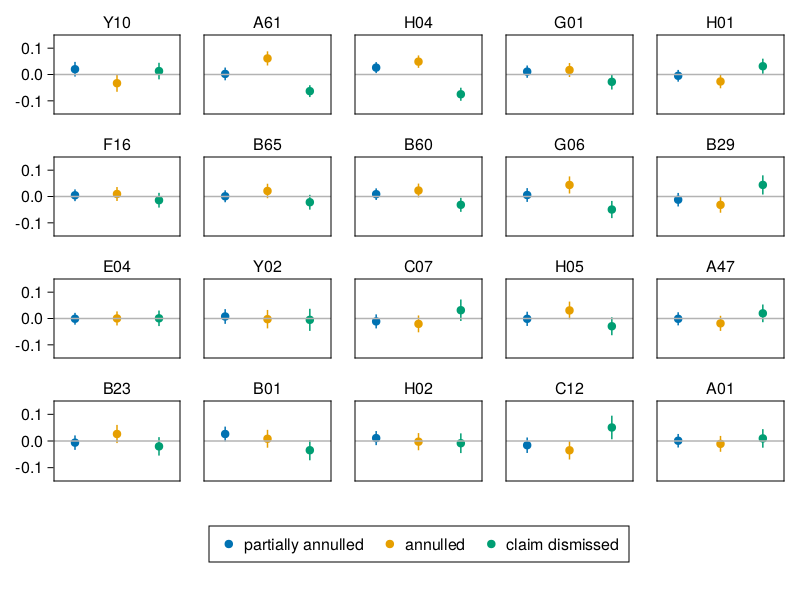

In [15]:
let groups = topkgroups(problem.cpcs, 20)
    ncols = 5
    labels = cpc2int(decisions, class)[2]
    
    fig = Figure(resolution=(800, 600))
    for (i, group) in enumerate(groups)
        probs = average_deviation(post, group; group=:cpc, groupsize=2)
        pos = fldmod1(i, ncols)
        ax = Axis(fig[pos...]; subtitle = labels[group])
        plot_average_deviation(ax, probs)
        hlines!(ax, 0; color=:grey70)
        hidexdecorations!(ax)
        ax.ygridvisible = false
        xlims!(ax, 0.5, 3.5)
        ylims!(ax, -.15, .15)
        last(pos) != 1 && (ax.yticksvisible = false; ax.yticklabelsvisible=false)
    end

    colors = Makie.wong_colors()
    lelems = [MarkerElement(color=colors[c], marker=:circle) for c in 1:3]
    Legend(fig[end+1, :], lelems, problem.outcome_labels; nbanks=3)
    
    fig
end

# board outcomes

In [16]:
using ArraysOfArrays
using Dictionaries, SplitApplyCombine

In [17]:
function count_outcomes(outcomes, groupvar)
    sortkeys(map(group(groupvar, outcomes)) do os
        [count(==(o), os) for o in 1:3]
    end)
end

count_outcomes (generic function with 1 method)

In [63]:
βs = map(post) do s
    map(z -> softmax(vcat(0, s.α .+ z .* s.σs)), s.zs)
end |> ArrayOfSimilarArrays |> flatview;

In [75]:
problem |> typeof |> fieldnames

(:outcomes, :outcome_labels, :js, :n_js, :N_js, :cpcs, :n_cpcs, :N_cpcs, :boards, :N_boards, :years, :N_years)

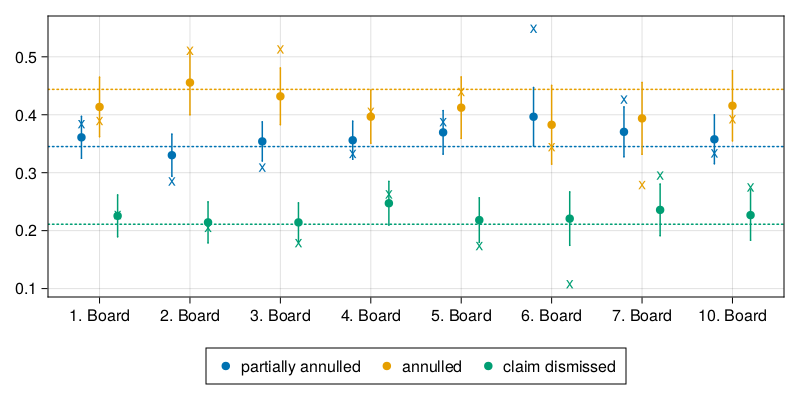

In [84]:
x = let 
    total = [count(==(o), problem.outcomes) for o in 1:3] ./ length(problem.outcomes)
    counts = count_outcomes(problem.outcomes, problem.boards)
    
    means = map(mean, eachrow(βs))
    sds = map(std, eachrow(βs))

    boardlabels = label.(sort(unique(board.(decisions)); by=id))

    fig = Figure(resolution=(800, 400))
    ax = Axis(fig[1,1])
    ax.xticks = (1:length(boardlabels), boardlabels)
    color = Makie.wong_colors()[1:3]

    hlines!(ax, total; color, linestyle=:dot)
    xpos(i) = [i-.2, i, i+.2]

    for i in eachindex(means)
        scatter!(ax, xpos(i), means[i]; color)
        scatter!(ax, xpos(i), counts[i] / sum(counts[i]); color, marker='x', markersize=16)
        errorbars!(ax, xpos(i), means[i], sds[i]; color)
    end

    lelems = [MarkerElement(color=color[c], marker=:circle) for c in 1:3]
    Legend(fig[end+1, :], lelems, problem.outcome_labels; nbanks=3, tellheight=true, tellwidth=false)

    fig
end

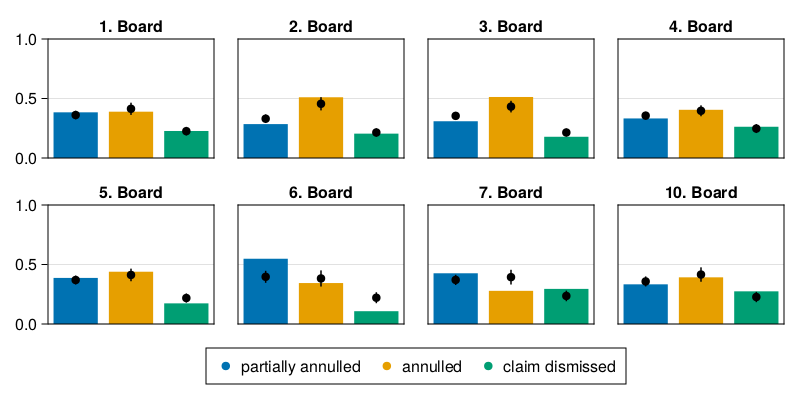

In [58]:
x = let 
    βs = map(post) do s
        map(z -> softmax(vcat(0, s.α .+ z .* s.σs)), s.zs)
    end |> ArrayOfSimilarArrays |> flatview

    means = map(mean, eachrow(βs))
    sds = map(std, eachrow(βs))
    counts = count_outcomes(problem.outcomes, problem.boards)

    boardlabels = label.(sort(unique(board.(decisions)); by=id))
    
    fig = Figure(resolution=(800, 400))
    colors = Makie.wong_colors()
    
    for i in eachindex(means)
        pos = fldmod1(i, 4)
        ax = Axis(fig[pos...]; title=boardlabels[i])
        barplot!(ax, 1:3, counts[i] ./ sum(counts[i]); color=colors[1:3])
        errorbars!(ax, 1:3, means[i], sds[i]; color=:black)
        scatter!(ax, 1:3, means[i]; color=:black)
        hidexdecorations!(ax)
        xlims!(ax, 0.5, 3.5)
        ylims!(ax, 0, 1)
        last(pos) != 1 && (ax.yticksvisible = false; ax.yticklabelsvisible=false)
    end

    lelems = [MarkerElement(color=colors[c], marker=:circle) for c in 1:3]
    Legend(fig[end+1, :], lelems, problem.outcome_labels; nbanks=3, tellheight=true)
    
    fig
end

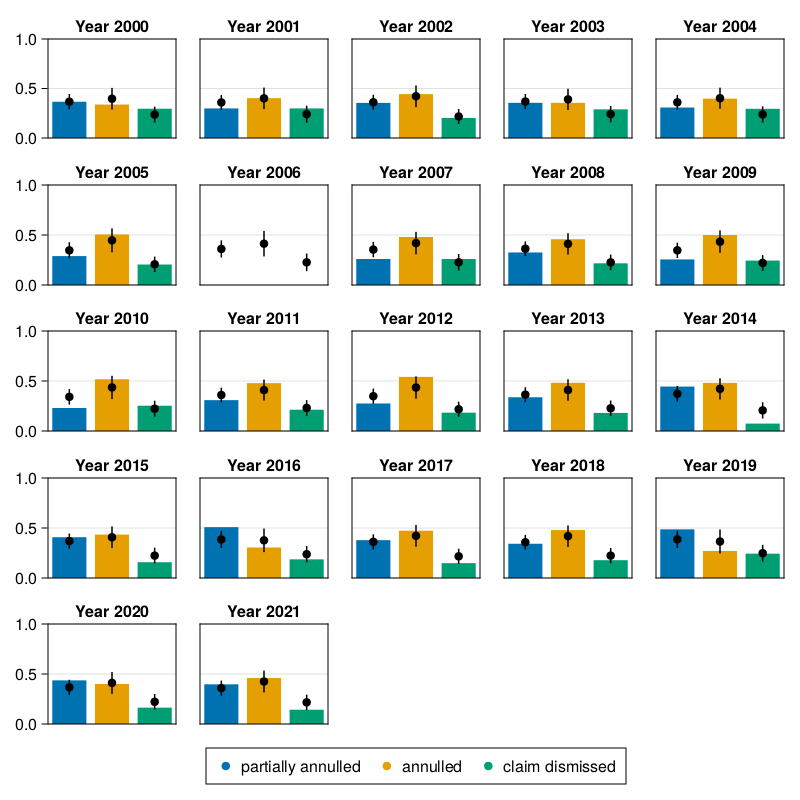

In [19]:
x = let 
    βs = map(post) do s
        map(z -> softmax(vcat(0, s.α .+ z .* s.σy)), s.zy)
    end |> ArrayOfSimilarArrays |> flatview

    means = map(mean, eachrow(βs))
    sds = map(std, eachrow(βs))
    counts = count_outcomes(problem.outcomes, problem.years)
    insert!(counts, 7, [0,0,0])
    sortkeys!(counts)
    
    fig = Figure(resolution=(800, 800))
    colors = Makie.wong_colors()
    
    for i in eachindex(means)
        pos = fldmod1(i, 5)
        ax = Axis(fig[pos...]; title="Year $(2000 - 1 + i)")
        barplot!(ax, 1:3, counts[i] ./ sum(counts[i]); color=colors[1:3])
        errorbars!(ax, 1:3, means[i], 2*sds[i]; color=:black)
        scatter!(ax, 1:3, means[i]; color=:black)
        hidexdecorations!(ax)
        xlims!(ax, 0.5, 3.5)
        ylims!(ax, 0, 1)
        last(pos) != 1 && (ax.yticksvisible = false; ax.yticklabelsvisible=false)
    end

    lelems = [MarkerElement(color=colors[c], marker=:circle) for c in 1:3]
    Legend(fig[end+1, :], lelems, problem.outcome_labels; nbanks=3, tellheight=true)
    
    fig
end

# Variance components

In [20]:
using ClipData

In [56]:
# summary table
let df = mapreduce(vcat, [:σs, :σy, :σj, :σt]) do σ
        r(x) = round(x; digits=2)
        res = map([first, last]) do f
            m = mean(f.(getproperty(post, σ))) |> r
            q = quantile(f.(getproperty(post, σ)), (.025, .975)) .|> r
            l = f(problem.outcome_labels[2:3])
            (label=l, par=σ, mean=m, ci=q)
        end
    end |> DataFrame

    df1 = unstack(df, :par, :label, :mean)
    df2 = unstack(df, :par, :label, :ci)
    leftjoin(df1, df2, on=:par; makeunique=true)
end |> cliptable

In [22]:
function plot_sds(problem, post)
    fig = Figure(resolution=(800,450))
    colors = Makie.wong_colors()

    plotsigma!(ax, draws; labels, legend=false) = begin
        hist!(first.(draws); bins=20, color=(colors[2], 0.7), label=labels[1])
        hist!(last.(draws); bins=20, color=(colors[3], 0.7), label=labels[2])
        hideydecorations!(ax)
        legend && axislegend(ax)
    end

    labels = problem.outcome_labels[2:3] 

    ax1 = Axis(fig[1,1]; titlealign=:left, title = "Board varying effect s.d.")
    plotsigma!(ax1, post.σs; labels)
    ax2 = Axis(fig[1,2]; titlealign=:left, title = "Year varying effect s.d.")
    plotsigma!(ax2, post.σy; labels, legend=true)
    ax3 = Axis(fig[2,1]; titlealign=:left, title = "Judge varying effect s.d.")
    plotsigma!(ax3, post.σj; labels)
    ax4 = Axis(fig[2,2]; titlealign=:left, title = "Technology varying effect s.d.")
    plotsigma!(ax4, post.σt; labels)

    fig
end

plot_sds (generic function with 1 method)

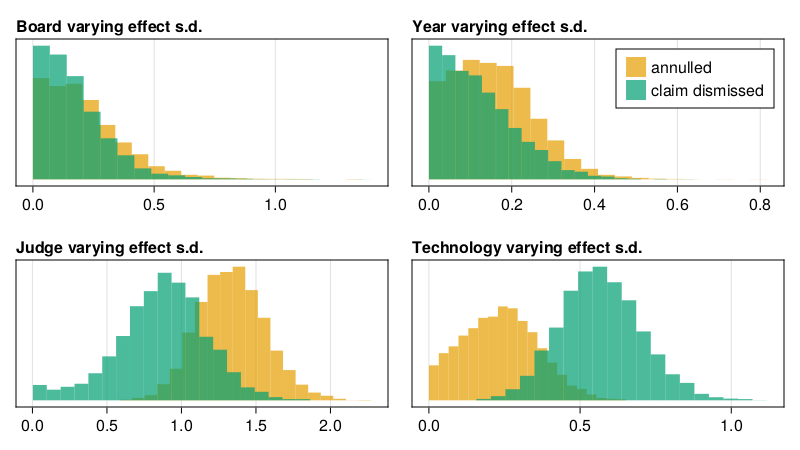

In [23]:
plot_sds(problem, post)

# Correlation among board and technology effects

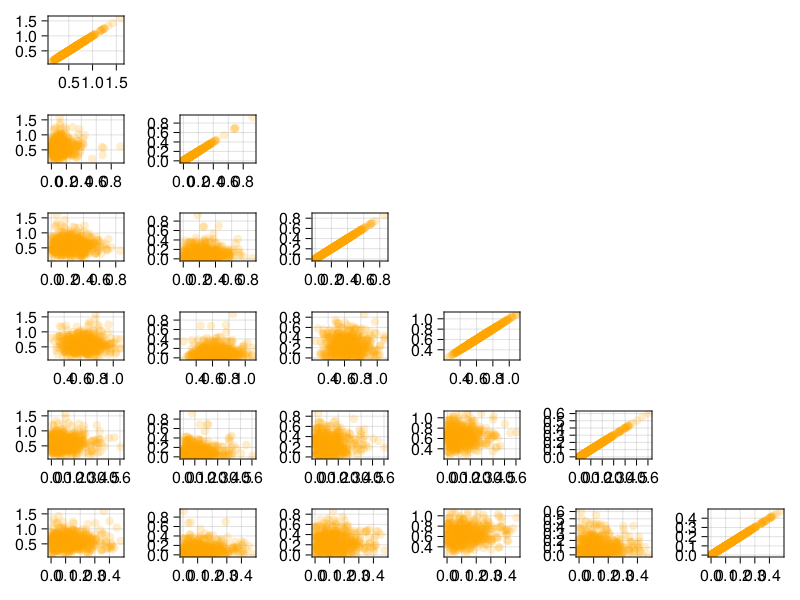

In [162]:
let mat = vcat(hcat(post.σs...), hcat(post.σt...), hcat(post.σy...))
    k = size(mat, 1)
    S = 500

    fig = Figure()

    for i in 1:k, j in 1:k
         j > i && continue
        ax = Axis(fig[i,j])
        scatter!(ax, mat[i,1:S], mat[j,1:S]; color=(:orange, 0.2))
    end

    fig
end

# Model accuracy

In [40]:
using Distributions

function predict(problem, θ)
    (; 
        outcomes, outcome_labels, 
        js, n_js, N_js, 
        cpcs, n_cpcs, N_cpcs,
        boards, N_boards,
        years, N_years,
    ) = problem

    (; α, zs, σs, zy, σy, zj, σj, zt, σt, ) = θ

    map(zip(outcomes, boards, years, js, n_js, cpcs, n_cpcs)) do (oi, si, yi, ji, nji, ti, nti)
        η = α + zs[si] .* σs + zy[yi] .* σy + 
            sum(zj[j] .* σj for j in ji) ./ nji +
            sum(zt[t] .* σt for t in ti) ./ nti
            
        Categorical(softmax(vcat(0.0, η))) |> rand
        #findmax(softmax(vcat(0.0, η)))[2]
    end
end

predict (generic function with 1 method)

In [41]:
tally(x::AbstractVector) = [r => count(==(r), x) for r in sort(unique(x))]

tally (generic function with 1 method)

In [42]:
tally(problem.outcomes)

3-element Vector{Pair{Int64, Int64}}:
 1 => 556
 2 => 715
 3 => 340

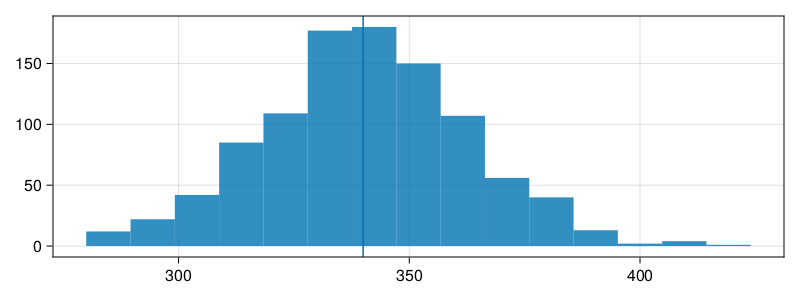

In [45]:
let o = 3 #dismissals
    pred = [count(==(o), predict(problem, θ)) for θ in first(post, 1000)]
    hist(pred; figure=(;resolution=(800, 300)))
    vlines!(count(==(o), problem.outcomes))
    current_figure()
end

In [46]:
function accuracy(problem, θ)
    mean(predict(problem, θ) .== problem.outcomes)
end

accuracy (generic function with 1 method)

In [50]:
function nullmodel(problem)
    N = length(problem.outcomes)
    probs = last.(tally(problem.outcomes)) ./ N
    rand(Categorical(probs), N)
end

nullmodel (generic function with 1 method)

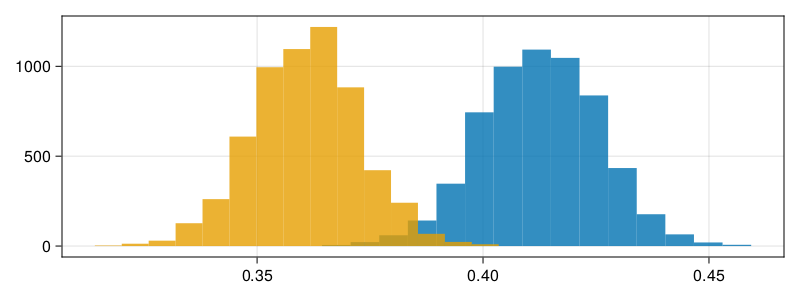

In [55]:
let N = length(problem.outcomes)
    acc_null = [count(nullmodel(problem) .== problem.outcomes) / N for _ in 1:6000]
    acc = [accuracy(problem, θ) for θ in post]
    hist(acc; figure=(;resolution=(800, 300)))
    hist!(acc_null)
    current_figure()
end